In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import sacc
import yaml

In [2]:
nzs_TQ = np.load('data/HSC/nz_realization.npz')
nzs_TQ

NpzFile 'data/HSC/nz_realization.npz' with keys: zbin, bin_0, bin_1, bin_2, bin_3

In [3]:
zbound = np.linspace(0.0,6.001,300)
zbin = (zbound[1:]+zbound[:-1])/2
nzs_TQ['bin_0'].shape
sels = [45, 70, 96, 99]

In [4]:
from scipy.interpolate import interp1d
import scipy.stats as stats

shifted_nzs = {}
for key in ["bin_0", "bin_1", "bin_2", "bin_3"]:
    print(key)
    nzs = nzs_TQ[key]
    stds = np.std(nzs, axis=1)
    s_stds = np.std(stds)
    m_stds = np.mean(stds)
    y = s_stds/m_stds
    mu = np.mean(nzs, axis=0)
    shift_prior = stats.norm(loc=0, scale=y)
    zs =  [zbin + shift_prior.rvs() for i in range(1000)]
    shifted_nzs[key] = [interp1d(z, mu, kind='linear', fill_value='extrapolate')(zbin) for z in zs]

bin_0
bin_1
bin_2
bin_3


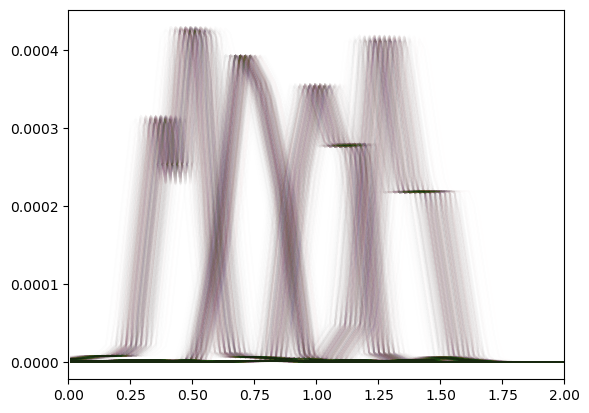

In [5]:
for key in list(shifted_nzs.keys()):
    nzs = shifted_nzs[key]
    for i in range(1000):
        plt.plot(zbin, nzs[i], alpha=0.005)
    plt.xlim(0, 2)

/tmp/ipykernel_31564/3367500922.py:13: RuntimeWarning: invalid value encountered in divide
  corr = cov / (np.outer(err, err))


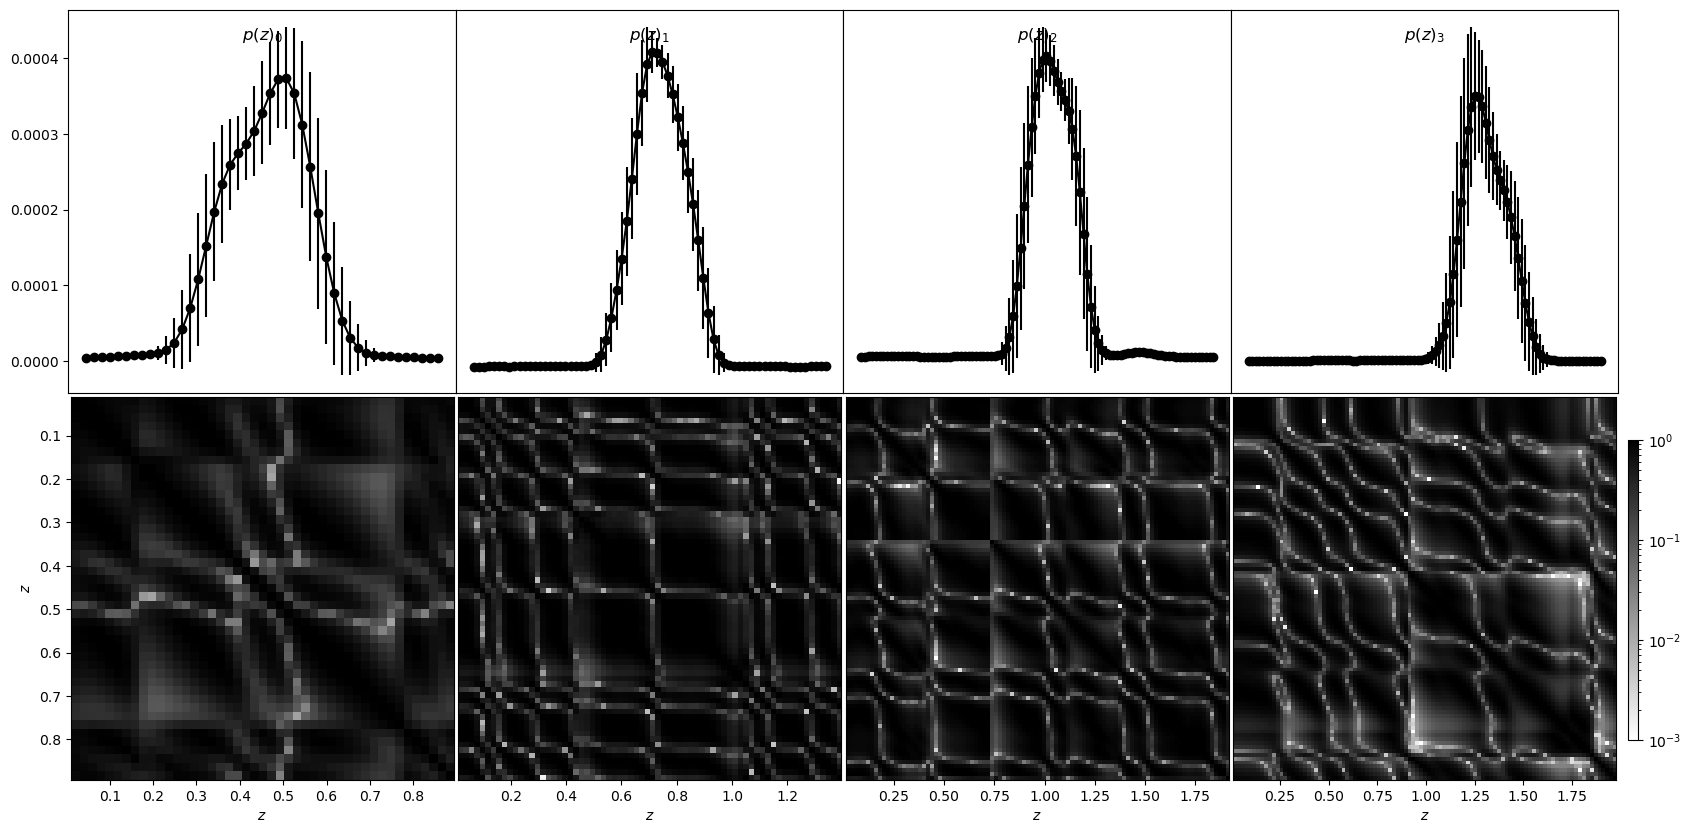

In [6]:
from matplotlib.colors import LogNorm
colorss = ["k", "k", "k", "k"]
figure, axis = plt.subplots(2, 4, figsize=(20,10))
figure.subplots_adjust(wspace=0, hspace=0.01)
i = 0
for name in list(shifted_nzs.keys()):
    nzs = np.array(shifted_nzs[name])
    m = np.mean(nzs, axis=0)
    s = np.std(nzs, axis=0)
    cov = np.cov(nzs.T)
    sel = sels[i]
    err = np.sqrt(np.diag(cov))
    corr = cov / (np.outer(err, err))
    axis[0 , i].errorbar(zbin[:sel], m[:sel], yerr=err[:sel],
                        fmt='{}o-'.format(colorss[i]),
                        label="$DESY1wl_{}$".format(i))
    #axis[0, i].set_ylim(0, 0.2)
    axis[0, i].set_title(r"$p(z)_{}$".format(i), y=0.9)
    axis[0, i].set_xticks([])
    im = axis[1, i].imshow(abs(corr[:sel, :sel]), cmap='gray_r', norm=LogNorm(vmin=0.001, vmax=1),
                        extent=[min(zbin[:sel]), max(zbin[:sel]), max(zbin[:sel]), min(zbin[:sel])])
    axis[1, i].set_xlabel(r"$z$")
    if i > 0:
        axis[0, i].set_yticks([])
        axis[1, i].set_yticks([])
    else:
        axis[1, i].set_ylabel(r"$z$")
    i += 1

cbar_ax = figure.add_axes([0.905, 0.15, 0.005, 0.3])
figure.colorbar(im, cax=cbar_ax)
plt.show()

/tmp/ipykernel_31564/1491472156.py:12: RuntimeWarning: invalid value encountered in divide
  corr = cov / (np.outer(err, err))


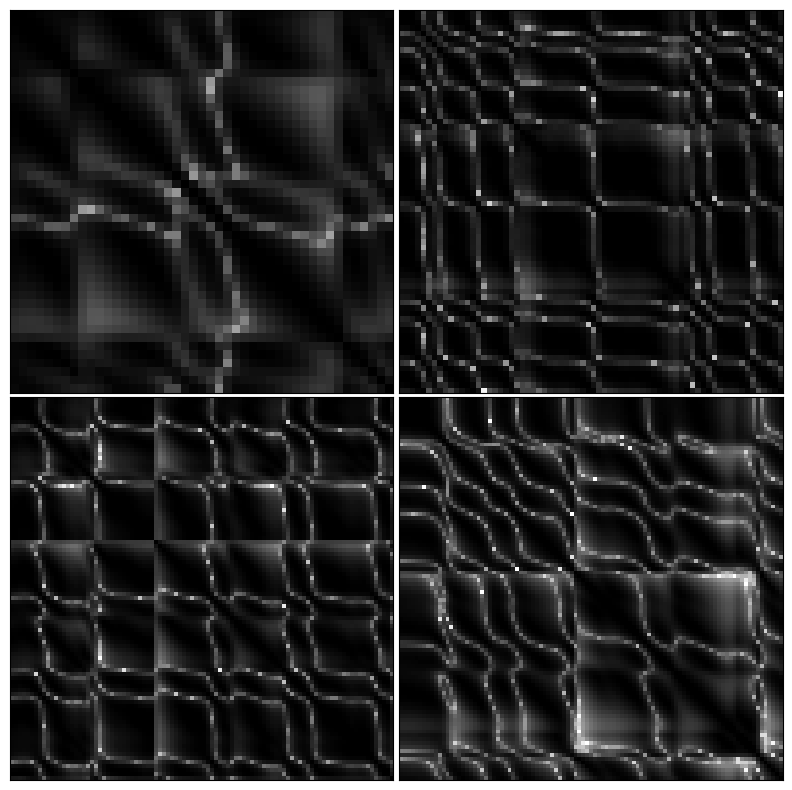

In [26]:
figure, axis = plt.subplots(2, 2, figsize=(10, 10))
figure.subplots_adjust(wspace=0.01, hspace=0.01)

i = 0
for name in list(shifted_nzs.keys()):
    nzs = np.array(shifted_nzs[name])
    m = np.mean(nzs, axis=0)
    s = np.std(nzs, axis=0)
    cov = np.cov(nzs.T)
    sel = sels[i]
    err = np.sqrt(np.diag(cov))
    corr = cov / (np.outer(err, err))
    ii = i // 2
    jj = i % 2
    axis[ii, jj].imshow(abs(corr[:sel, :sel]), cmap='gray_r', norm=LogNorm(vmin=0.001, vmax=1),
                                    extent=[min(zbin[:sel]), max(zbin[:sel]), max(zbin[:sel]), min(zbin[:sel])])
    axis[ii, jj].set_yticks([])
    axis[ii, jj].set_xticks([])
    i += 1

plt.show()

43
73
98
99


/tmp/ipykernel_31564/4207308000.py:16: RuntimeWarning: invalid value encountered in divide
  corr = cov / (np.outer(err, err))


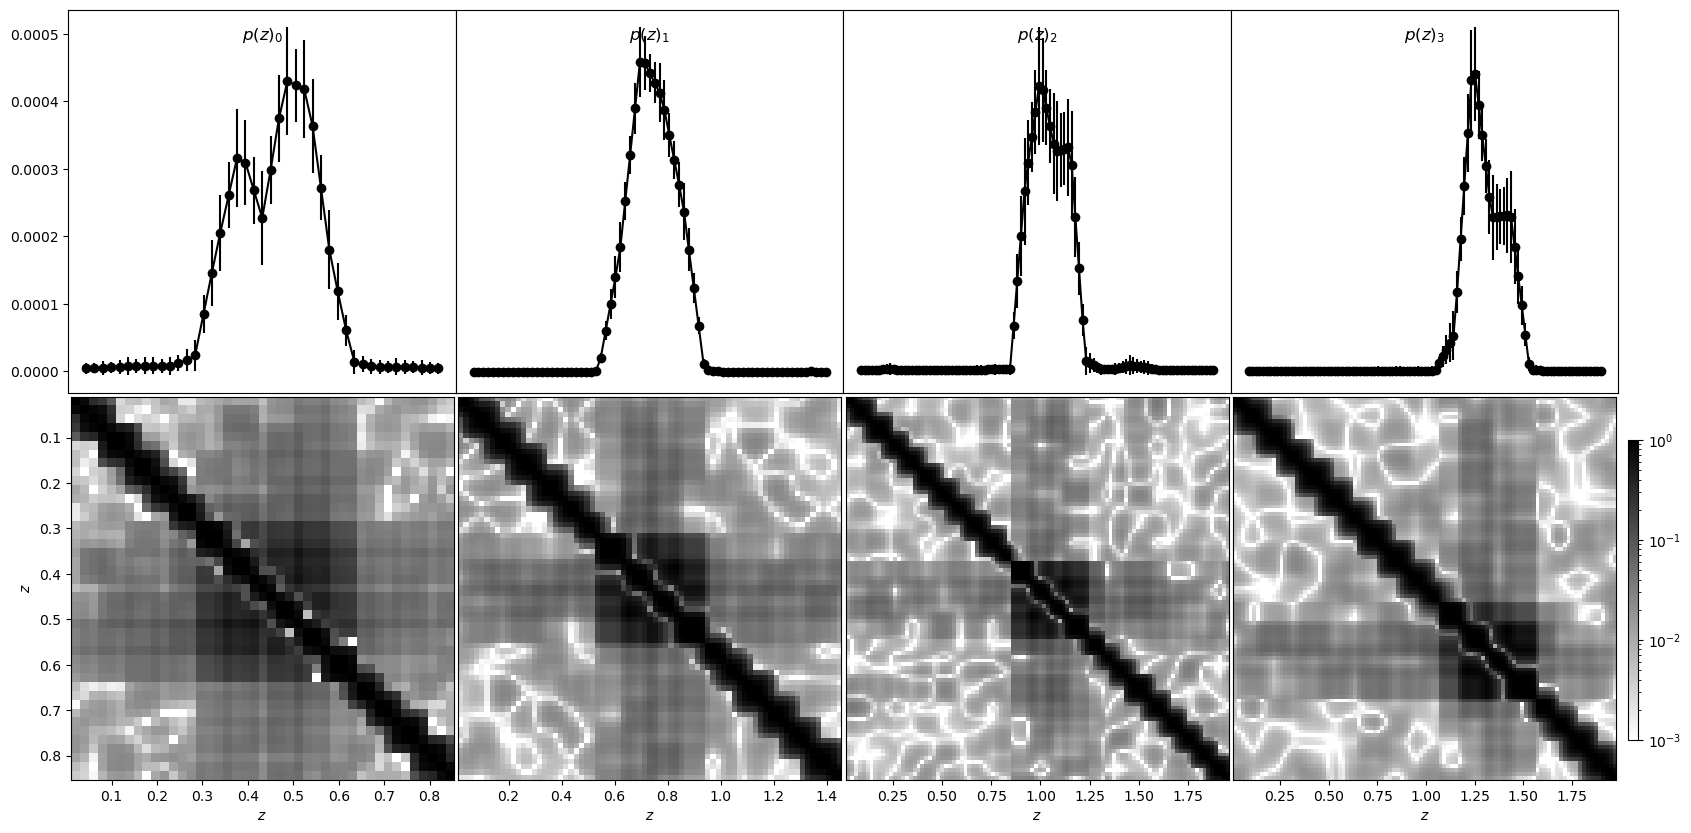

In [7]:
from matplotlib.colors import LogNorm
colorss = ["k", "k", "k", "k"]
figure, axis = plt.subplots(2, 4, figsize=(20,10))
figure.subplots_adjust(wspace=0, hspace=0.01)
i = 0
for name in ["bin_0", "bin_1", "bin_2", "bin_3"]:
    nzs = nzs_TQ[name]
    m = np.mean(nzs, axis=0)
    s = np.std(nzs, axis=0)
    cov = np.cov(nzs.T)
    sel = cov[0, :] > 0
    sel, = np.where(zbin == zbin[sel][-1])
    sel = sel[0]
    print(sel)
    err = np.sqrt(np.diag(cov))
    corr = cov / (np.outer(err, err))
    axis[0 , i].errorbar(zbin[:sel], m[:sel], yerr=err[:sel],
                        fmt='{}o-'.format(colorss[i]),
                        label="$DESY1wl_{}$".format(i))
    #axis[0, i].set_ylim(0, 0.2)
    axis[0, i].set_title(r"$p(z)_{}$".format(i), y=0.9)
    axis[0, i].set_xticks([])
    im = axis[1, i].imshow(abs(corr[:sel, :sel]), cmap='gray_r', norm=LogNorm(vmin=0.001, vmax=1),
                        extent=[min(zbin[:sel]), max(zbin[:sel]), max(zbin[:sel]), min(zbin[:sel])])
    axis[1, i].set_xlabel(r"$z$")
    if i > 0:
        axis[0, i].set_yticks([])
        axis[1, i].set_yticks([])
    else:
        axis[1, i].set_ylabel(r"$z$")
    i += 1

cbar_ax = figure.add_axes([0.905, 0.15, 0.005, 0.3])
figure.colorbar(im, cax=cbar_ax)
plt.show()

/tmp/ipykernel_31564/157078236.py:12: RuntimeWarning: invalid value encountered in divide
  corr = cov / (np.outer(err, err))


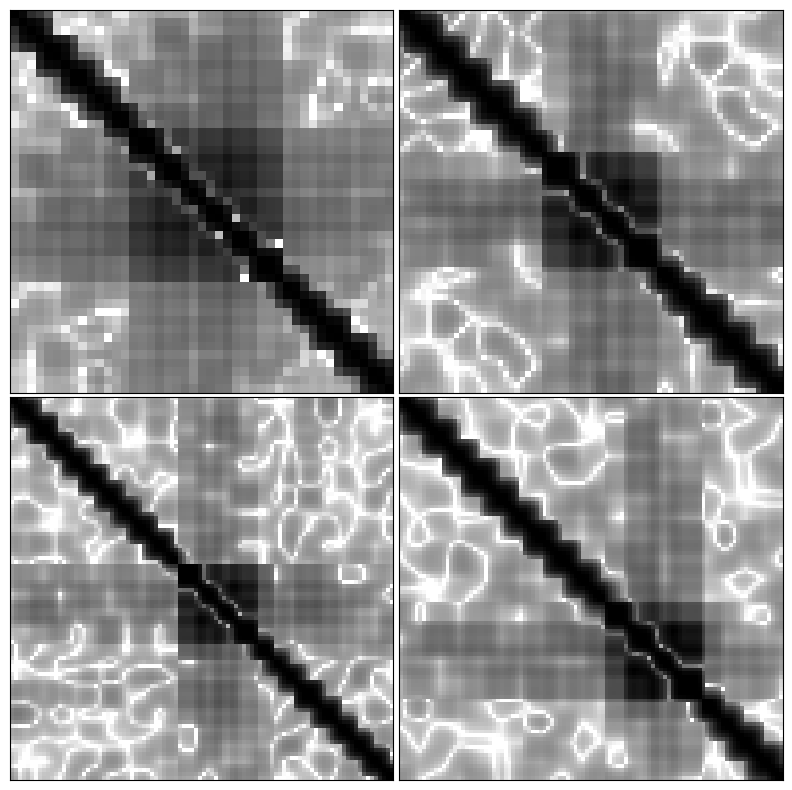

In [ ]:
figure, axis = plt.subplots(2, 2, figsize=(10, 10))
figure.subplots_adjust(wspace=0.01, hspace=0.01)

i = 0
for name in ["bin_0", "bin_1", "bin_2", "bin_3"]:
    nzs = np.array(nzs_TQ[name])
    m = np.mean(nzs, axis=0)
    s = np.std(nzs, axis=0)
    cov = np.cov(nzs.T)
    sel = sels[i]
    err = np.sqrt(np.diag(cov))
    corr = cov / (np.outer(err, err))
    ii = i // 2
    jj = i % 2
    axis[ii, jj].imshow(abs(corr[:sel, :sel]), cmap='gray_r', norm=LogNorm(vmin=0.001, vmax=1),
                            extent=[min(zbin[:sel]), max(zbin[:sel]), max(zbin[:sel]), min(zbin[:sel])])
    axis[ii, jj].set_yticks([])
    axis[ii, jj].set_xticks([])
    i += 1

plt.show()